# Pairwise attacks
### Analysis and visualization
With pairwise attacks we check if it is possible to trace back an image from the candidate dataset back to the training set by finding a very similar image in the synthetic set.<br/>
We run the analysis by looking at the most similar pairs between candidate and synthetic samples and assess if this similarity is a strong enough parameter for reliably identifying training samples.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import umap

from glob import glob
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import pickle

from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from sklearn.metrics import roc_curve, auc

#### Loading data

In [17]:
# Loading pixel space distances
L2_dist = np.load('./privacy_saves/L2_candidate_syth.npy', allow_pickle=True)
L2_dist_test = np.load('./privacy_saves/L2_test_synth.npy', allow_pickle=True)
norm_L2_dist = (L2_dist.min(axis=1))/np.median(L2_dist, axis=1)

In [18]:
# Loading feature space distances
umap_dist_candidate_synth = np.load('./privacy_saves/umap_dist_candidate_synth.npy', allow_pickle=True)
umap_dist_test_synth = np.load('./privacy_saves/umap_dist_test_synth.npy', allow_pickle=True)
norm_umap_dist = (umap_dist_candidate_synth.min(axis=1))/np.median(umap_dist_candidate_synth, axis=1)

#### Visualization

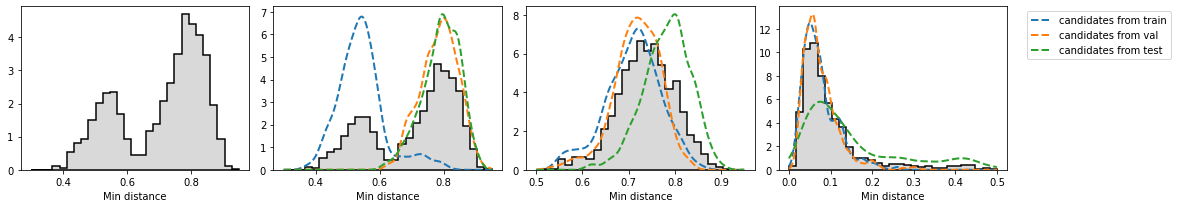

In [19]:
# Simulating a privacy threatening scenario with 1D samples
# a and b represent training samples; c represents validation; d represents testing samples
a = np.random.beta(9, 4, 450)*0.4 +0.25
b = np.random.beta(12, 7, 50)*0.5 +0.4
c = np.random.beta(12, 7, 500)*0.5 +0.47
d = np.random.beta(9, 3, 500)*0.52 +0.4
simulated_distribution = np.concatenate((a,b,c,d))

# Generating matplotlib layout
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(18, 3))

# 1st figure is histogram of the distances of the toy distribution
# This represents a privacy threatening case 
hand_bins = np.linspace(0.3,0.95,30)
kde_lag = np.linspace(0.3,0.95,300)
ax[0].hist(simulated_distribution[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

ax[0].set_xlabel('Min distance')

###########
# 2nd figure is histogram of the toy distribution with subdistribution based on the origins of samples overlayed on top
# This represents a privacy threatening case 

hand_bins = np.linspace(0.3,0.95,30)
kde_lag = np.linspace(0.3,0.95,300)
ax[1].hist(simulated_distribution[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(np.concatenate((a,b)), bw_method=0.25)
ax[1].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')

density_2 = gaussian_kde(c, bw_method=0.25)
ax[1].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')

density_3 = gaussian_kde(d, bw_method=0.25)
ax[1].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[1].set_xlabel('Min distance')

###########
# 3rd figure is histogram of the observed distribution of the closest pairs based on similarity in pixel space (L2 dist)
# with subdistribution based on the origins of samples overlayed on top

hand_bins = np.linspace(0.5,0.95,30)
kde_lag = np.linspace(0.5,0.95,300)

cmap = plt.get_cmap("Paired")
ax[2].hist(norm_L2_dist[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(norm_L2_dist[:334], bw_method=0.25)
ax[2].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')
density_2 = gaussian_kde(norm_L2_dist[334:667], bw_method=0.25)
ax[2].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')
density_3 = gaussian_kde(norm_L2_dist[667:], bw_method=0.25)
ax[2].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[2].set_xlabel('Min distance')


###########
# 3rd figure is histogram of the observed distribution of the closest pairs based on similarity in feature space
# (L2 dist on features) with subdistribution based on the origins of samples overlayed on top

hand_bins = np.linspace(0,0.5,30)
kde_lag = np.linspace(0,0.5,300)

cmap = plt.get_cmap("Paired")
ax[3].hist(norm_umap_dist[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(norm_umap_dist[:334], bw_method=0.2)
ax[3].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0', label='candidates from train')
density_2 = gaussian_kde(norm_umap_dist[334:667], bw_method=0.2)
ax[3].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1', label='candidates from val')
density_3 = gaussian_kde(norm_umap_dist[667:], bw_method=0.2)
ax[3].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2', label='candidates from test')
ax[3].set_xlabel('Min distance')

fig.legend(loc='upper right', bbox_to_anchor=(0.91,0.95))
fig.tight_layout()
fig.subplots_adjust(right=0.78)
plt.savefig('./images/privacy_distance_top.png', dpi=300)
plt.show()

# Supplemental

### Histograms with reference

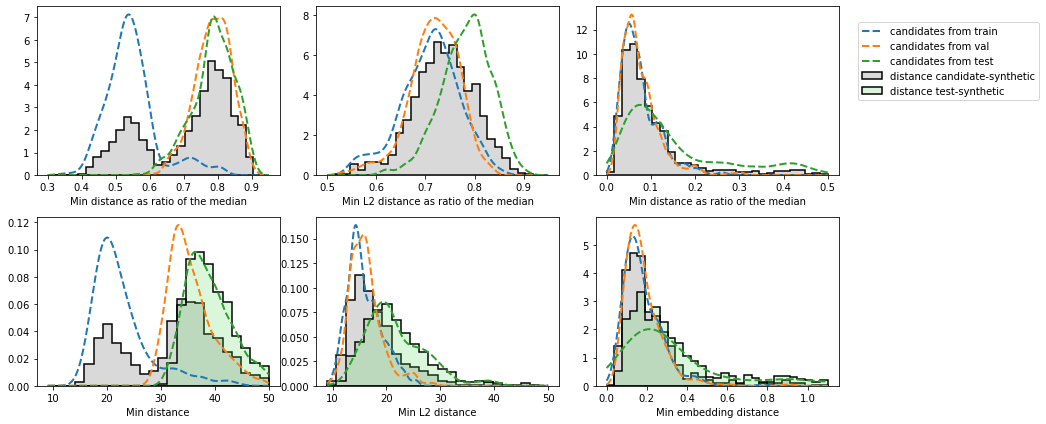

In [20]:
# Simulating a privacy threatening scenario with 1D samples
# a and b represent training samples; c represents validation; d represents testing samples
a = np.random.beta(9, 4, 450)*0.4 +0.25
b = np.random.beta(12, 7, 50)*0.5 +0.4
c = np.random.beta(12, 7, 500)*0.5 +0.47
d = np.random.beta(9, 3, 500)*0.52 +0.4
simulated_distribution = np.concatenate((a,b,c,d))

# Generating matplotlib layout
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 6))

# (Row 1, Col 1) figure is histogram of the toy distribution with 
# subdistribution based on the origins of samples overlayed on top. This represents a privacy threatening case

hand_bins = np.linspace(0.3,0.95,30)
kde_lag = np.linspace(0.3,0.95,300)
ax[0, 0].hist(simulated_distribution[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(np.concatenate((a,b)), bw_method=0.25)
ax[0, 0].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')

density_2 = gaussian_kde(c, bw_method=0.25)
ax[0, 0].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')

density_3 = gaussian_kde(d, bw_method=0.25)
ax[0, 0].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[0, 0].set_xlabel('Min distance as ratio of the median')

###########
# (Row 1, Col 2) histogram of the observed distribution of the closest pairs based on similarity in pixel space (L2 dist)
# subdistribution based on the origins of samples overlayed on top.

hand_bins = np.linspace(0.5,0.95,30)
kde_lag = np.linspace(0.5,0.95,300)

cmap = plt.get_cmap("Paired")
ax[0, 1].hist(norm_L2_dist[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(norm_L2_dist[:334], bw_method=0.25)
ax[0, 1].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')
density_2 = gaussian_kde(norm_L2_dist[334:667], bw_method=0.25)
ax[0, 1].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')
density_3 = gaussian_kde(norm_L2_dist[667:], bw_method=0.25)
ax[0, 1].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[0, 1].set_xlabel('Min L2 distance as ratio of the median')


###########
# (Row 1, Col 3) histogram of the observed distribution of the closest pairs based on similarity in feature space 
# (L2 dist on features); subdistribution based on the origins of samples overlayed on top.

hand_bins = np.linspace(0,0.5,30)
kde_lag = np.linspace(0,0.5,300)

cmap = plt.get_cmap("Paired")
ax[0, 2].hist(norm_umap_dist[:], color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(norm_umap_dist[:334], bw_method=0.2)
ax[0, 2].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')
density_2 = gaussian_kde(norm_umap_dist[334:667], bw_method=0.2)
ax[0, 2].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')
density_3 = gaussian_kde(norm_umap_dist[667:], bw_method=0.2)
ax[0, 2].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[0, 2].set_xlabel('Min distance as ratio of the median')


###########
# (Row 2, Col 1) figure is histogram of the toy distribution.
# Reference distance given by test vs synthetic to define outliers 
# subdistribution based on the origins of samples overlayed on top. This represents a privacy threatening case

a = (np.random.gamma(shape= 5, scale=0.75,size=450)+7)*2
b = (np.random.gamma(shape= 4, scale=1,size=50)+13)*2.1
c = (np.random.gamma(shape= 4, scale=1,size=500)+13)*2.1
d = (np.random.gamma(shape= 4, scale=1,size=500)+13)*2.3

e = (np.random.gamma(shape= 4, scale=1,size=500)+12.9)*2.34
simulated_distribution = np.concatenate((a,b,c,d))


hand_bins = np.linspace(9,50,25)
kde_lag = np.linspace(9,50,300)

cmap = plt.get_cmap("Paired")
ax[1, 0].hist(simulated_distribution, color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')
ax[1, 0].hist(e, color=[0.3, 0.85, 0.3, 0.2],bins=hand_bins,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(np.concatenate((a,b)), bw_method=0.25)
ax[1, 0].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')

density_2 = gaussian_kde(c, bw_method=0.25)
ax[1, 0].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')

density_3 = gaussian_kde(d, bw_method=0.25)
ax[1, 0].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[1, 0].set_xlabel('Min distance')

###########
# (Row 1, Col 2) histogram of the observed distribution of the closest pairs based on similarity in pixel space (L2 dist)
# Reference distance given by test vs synthetic to define outliers 
# subdistribution based on the origins of samples overlayed on top.

hand_bins = np.linspace(9,50,25)
kde_lag = np.linspace(9,50,300)

cmap = plt.get_cmap("Paired")
ax[1, 1].hist(L2_dist[:].min(axis=1), color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')
ax[1, 1].hist(L2_dist_test[:].min(axis=1), color=[0.3, 0.85, 0.3, 0.2],bins=hand_bins,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled')

density_1 = gaussian_kde(L2_dist[:334].min(axis=1), bw_method=0.2)
ax[1, 1].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0')
density_2 = gaussian_kde(L2_dist[334:667].min(axis=1), bw_method=0.2)
ax[1, 1].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1')
density_3 = gaussian_kde(L2_dist[667:].min(axis=1), bw_method=0.2)
ax[1, 1].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2')
ax[1, 1].set_xlabel('Min L2 distance')



###########
# (Row 1, Col 3) histogram of the observed distribution of the closest pairs based on similarity in feature space
# Reference distance given by test vs synthetic to define outliers 
# (L2 dist on features); subdistribution based on the origins of samples overlayed on top.

hand_bins = np.linspace(0,1.10,30)
kde_lag = np.linspace(0,1.10,300)

cmap = plt.get_cmap("Paired")
ax[1, 2].hist(umap_dist_candidate_synth[:].min(axis=1), color=[0.85, 0.85, 0.85],bins=hand_bins ,alpha=1,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled', label='distance candidate-synthetic')
ax[1, 2].hist(umap_dist_test_synth[:].min(axis=1), color=[0.3, 0.85, 0.3, 0.2],bins=hand_bins,density=True,lw=1.5,
         edgecolor="black", histtype='stepfilled', label='distance test-synthetic')

density_1 = gaussian_kde(umap_dist_candidate_synth[:334].min(axis=1), bw_method=0.25)
ax[1, 2].plot(kde_lag,density_1(kde_lag), linestyle='--', lw=2, color='C0', label='candidates from train')
density_2 = gaussian_kde(umap_dist_candidate_synth[334:667].min(axis=1), bw_method=0.25)
ax[1, 2].plot(kde_lag,density_2(kde_lag), linestyle='--', lw=2, color='C1', label='candidates from val')
density_3 = gaussian_kde(umap_dist_candidate_synth[667:].min(axis=1), bw_method=0.25)
ax[1, 2].plot(kde_lag,density_3(kde_lag), linestyle='--', lw=2, color='C2', label='candidates from test')
ax[1, 2].set_xlabel('Min embedding distance')
fig.legend(loc='upper right', bbox_to_anchor=(0.97,0.95))
fig.tight_layout()
fig.subplots_adjust(right=0.78)
plt.savefig('./images/privacy_distance.png', dpi=300)
plt.show()

### Redefine simulated distribution
For supplemental figure subplot 2nd row, 1st column, simulated distribution is tweaked to match the range of observed values. We rectify that to match the main plot.

In [33]:
a = np.random.beta(9, 4, 450)*0.4 +0.25
b = np.random.beta(12, 7, 50)*0.5 +0.4
c = np.random.beta(12, 7, 500)*0.5 +0.47
d = np.random.beta(9, 3, 500)*0.52 +0.4
simulated_distribution = np.concatenate((a,b,c,d))

### Anomaly detection Cut off
Quantitative analysis of information from training carried over into the synthetic dataset.<br/>
We define a threshold (cut off) based on distances/similarity after which the samples are considered outliers. We then compare the proportion of these outliers coming from train/validation/test.<br/>
Privacy threatening is when most of the outliers come from train.

In [34]:
def origin_pred(dist, cut_off=100):
    '''For run classification for the top N (cut off) smallest distances
    'dist' are the distances from candidates (either L2 in pixel or L2 in feature space)
    First 334 indexes of candidates distances are training, next 333 are val, final 333 are test
    After sorting we look at the original index to classify based on distance
    Returns the proportion of training vs validation + training and proportion of training vs test + training'''
    
    ind_sort_dist = np.argsort(dist)[:cut_off]
    pred_train = ind_sort_dist[ind_sort_dist<334]
    
    temp = ind_sort_dist[~(ind_sort_dist<334)]
    pred_val = temp[temp<667]
    
    temp = ind_sort_dist[~(ind_sort_dist<667)]
    pred_test = temp[temp<1001]
    
    total = len(pred_train) + len(pred_val) + len(pred_test)
    percent = [len(pred_train)/total, len(pred_val)/total, len(pred_test)/total]
    return len(pred_train)/(len(pred_val)+len(pred_train)), len(pred_train)/(len(pred_test)+len(pred_train)), percent

In [35]:
def origin_pred_custom(dist, cut_off=100):
    '''Same as origin_pred expect it works for the toy/simulated privacy threatening dataset
    500 first distances are from training, 500 next are val and last 500 are test'''
    ind_sort_dist = np.argsort(dist)[:cut_off]
    pred_train = ind_sort_dist[ind_sort_dist<500]
    
    temp = ind_sort_dist[~(ind_sort_dist<500)]
    pred_val = temp[temp<1000]
    
    temp = ind_sort_dist[~(ind_sort_dist<1000)]
    pred_test = temp[temp<1501]

    total = len(pred_train) + len(pred_val) + len(pred_test)
    percent = [len(pred_train)/total, len(pred_val)/total, len(pred_test)/total]
    return len(pred_train)/(len(pred_val)+len(pred_train)), len(pred_train)/(len(pred_test)+len(pred_train)), percent

In [36]:
# Cut off for printing intermediate results
cut_off = 333

In [37]:
# Classify for pixel space (val and test)
class_list_val = []
class_list_test = []
percent_list = []

for curr_cut_off in range(5, 999):
    val, test, percent = origin_pred(norm_L2_dist, curr_cut_off)
    class_list_val.append(val)
    class_list_test.append(test)
    percent_list.append(percent)

print('val {:.2f}'.format(class_list_val[cut_off]))
print('test {:.2f}'.format(class_list_test[cut_off]))
print('train {:.2f}, val {:.2f}, test {:.2f}'.format(percent_list[cut_off][0],
                                                     percent_list[cut_off][1],
                                                     percent_list[cut_off][2]))

val 0.53
test 0.83
train 0.48, val 0.43, test 0.09


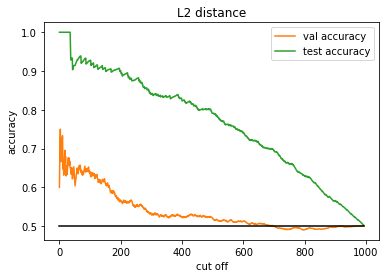

In [38]:
# Plot for anomaly detection in pixel space (native L2 distance)

plt.plot(class_list_val, color='C1', label='val accuracy')
plt.plot(class_list_test, color='C2', label='test accuracy')
plt.legend()
plt.xlabel('cut off')
plt.ylabel('accuracy')
plt.plot(np.ones(len(class_list_test))*0.5, color='black')
plt.title('L2 distance')
plt.savefig('./images/supp/Supp_L2_dist_cutoff.png', dpi=300)
plt.show()

In [39]:
# Classify for feature space (val and test)
class_list_val = []
class_list_test = []
percent_list = []

for curr_cut_off in range(5, 999):
    val, test, percent = origin_pred(norm_umap_dist, curr_cut_off)
    class_list_val.append(val)
    class_list_test.append(test)
    percent_list.append(percent)
    
print('val {:.2f}'.format(class_list_val[cut_off]))
print('test {:.2f}'.format(class_list_test[cut_off]))
print('train {:.2f}, val {:.2f}, test {:.2f}'.format(percent_list[cut_off][0],
                                                     percent_list[cut_off][1],
                                                     percent_list[cut_off][2]))

val 0.53
test 0.69
train 0.43, val 0.38, test 0.19


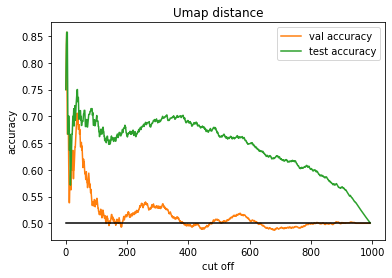

In [27]:
# Plot for anomaly detection in feature space

plt.plot(class_list_val, color='C1', label='val accuracy')
plt.plot(class_list_test, color='C2', label='test accuracy')
plt.legend()
plt.xlabel('cut off')
plt.ylabel('accuracy')
plt.plot(np.ones(len(class_list_test))*0.5, color='black')
plt.title('Umap distance')
plt.savefig('./images/supp/Supp_umap_dist_cutoff.png', dpi=300)
plt.show()

In [41]:
class_list_val = []
class_list_test = []
percent_list = []

for curr_cut_off in range(5, 1499):
    val, test, percent = origin_pred_custom(simulated_distribution, curr_cut_off)
    class_list_val.append(val)
    class_list_test.append(test)
    percent_list.append(percent)
    
print('val {:.2f}'.format(class_list_val[cut_off]))
print('test {:.2f}'.format(class_list_test[cut_off]))
print('train {:.2f}, val {:.2f}, test {:.2f}'.format(percent_list[cut_off][0],
                                                     percent_list[cut_off][1],
                                                     percent_list[cut_off][2]))

val 1.00
test 1.00
train 1.00, val 0.00, test 0.00


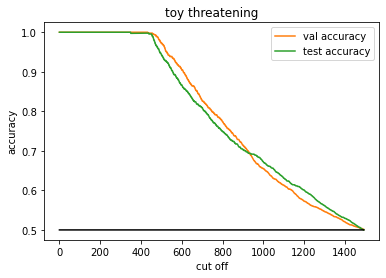

In [42]:
plt.plot(class_list_val, color='C1', label='val accuracy')
plt.plot(class_list_test, color='C2', label='test accuracy')
plt.legend()
plt.xlabel('cut off')
plt.ylabel('accuracy')
plt.plot(np.ones(len(class_list_test))*0.5, color='black')
plt.title('toy threatening')
plt.savefig('./images/supp/Supp_threatening_dist_cutoff.png', dpi=300)
plt.show()

### ROC curve
Classifying based on distance (low distance being resulting in a prediction of a training sample is considered a True positive)

In [31]:
def roc_custom(dist_list):
    '''Compute roc curve for candidate in pixel and feature space'''
    
    # Getting labels based on origin from candidate dataset
    train_list = dist_list[:334]
    val_list = dist_list[334:667]
    test_list = dist_list[667:]
    
    # Running normalization on the distance to get values between 0 and 1
    # normalize val vs train
    norm_val = np.concatenate((train_list, val_list))
    norm_val = norm_val - np.min(norm_val)
    norm_val = norm_val*(1/np.max(norm_val))
    norm_val = 1 - norm_val
    
    # normalize test vs train
    norm_test = np.concatenate((train_list, test_list))
    norm_test = norm_test - np.min(norm_test)
    norm_test = norm_test*(1/np.max(norm_test))
    norm_test = 1 - norm_test
    
    # define positive and negative labels
    # ealier samples are always training so labeled as positive
    labels = np.concatenate((np.ones([334]), np.zeros([333])))
    
    # Get false positve and true positive rate
    fpr_val, tpr_val, _ = roc_curve(labels, norm_val)
    fpr_test, tpr_test, _ = roc_curve(labels, norm_test)

    return fpr_val, tpr_val, fpr_test, tpr_test

In [38]:
def roc_custom_simul(dist_list):
    '''Compute roc curve for Toy example
    Only difference is the sample size being on 1500 points instead of 1000
    refer to roc_custom for details'''
    train_list = dist_list[:500]
    val_list = dist_list[500:1000]
    test_list = dist_list[1000:]

    norm_val = np.concatenate((train_list, val_list))
    norm_val = norm_val - np.min(norm_val)
    norm_val = norm_val*(1/np.max(norm_val))
    norm_val = 1 - norm_val

    norm_test = np.concatenate((train_list, test_list))
    norm_test = norm_test - np.min(norm_test)
    norm_test = norm_test*(1/np.max(norm_test))
    norm_test = 1 - norm_test

    labels = np.concatenate((np.ones([500]), np.zeros([500])))

    fpr_val, tpr_val, _ = roc_curve(labels, norm_val)
    fpr_test, tpr_test, _ = roc_curve(labels, norm_test)

    return fpr_val, tpr_val, fpr_test, tpr_test

In [41]:
# Run roc curve for pixel space and feature space
fpr_val, tpr_val, fpr_test, tpr_test = roc_custom(norm_L2_dist)
fpr_umap_val, tpr_umap_val, fpr_umap_test, tpr_umap_test = roc_custom(norm_umap_dist)
# Run custom for simulated distribution
fpr_val_simul, tpr_val_simul, fpr_test_simul, tpr_test_simul = roc_custom_simul(simulated_distribution)

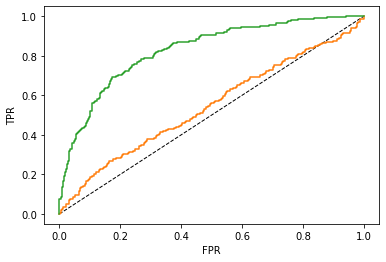

In [44]:
# Plot ROC curve for Pixel space (Native L2)

plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), color='black', linestyle='--', lw=1)
plt.plot(fpr_val, tpr_val, color='C1', label='L2 val')
plt.plot(fpr_test, tpr_test, color='C2', label='L2 test')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('./images/supp/ROC_L2_pairwise.png', dpi=300)
plt.show()

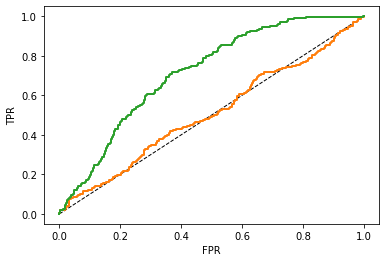

In [45]:
# Plot ROC curve for Feature space (Embedding with umap)

plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), color='black', linestyle='--', lw=1)
plt.plot(fpr_umap_val, tpr_umap_val, color='C1', lw=2, label='umap val')
plt.plot(fpr_umap_test, tpr_umap_test, color='C2', lw=2, label='umap test')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('./images/supp/ROC_umap_pairwise.png', dpi=300)
plt.show()

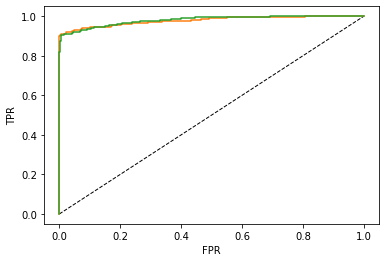

In [43]:
# Run on toy example with privacy threatening behavior

plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), color='black', linestyle='--', lw=1)
plt.plot(fpr_val_simul, tpr_val_simul, color='C1', label='L2 val')
plt.plot(fpr_test_simul, tpr_test_simul, color='C2', label='L2 test')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.savefig('./images/supp/ROC_threatening_pairwise.png', dpi=300)
plt.show()